In [3]:
import numpy as np
import torch
import onnxruntime as ort
from pathlib import Path
import json
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns

# ==================== 1. 数据加载 ====================
class CLIPEvaluator:
    def __init__(self, fp32_model_path, int8_model_path, image_dir, annotations_path):
        self.fp32_model_path = fp32_model_path
        self.int8_model_path = int8_model_path
        self.image_dir = Path(image_dir)
        self.annotations_path = annotations_path

        # 初始化会话
        self.sess_fp32 = ort.InferenceSession(str(fp32_model_path))
        self.sess_int8 = ort.InferenceSession(str(int8_model_path))

        # 数据预处理
        self.preprocess = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48145466, 0.4578275, 0.40821073],
                std=[0.26862954, 0.26130258, 0.27577711]
            )
        ])

        # 加载标注
        with open(annotations_path) as f:
            self.coco = json.load(f)

    def extract_image_features(self, model_type='fp32'):
        """提取所有图像特征"""
        sess = self.sess_fp32 if model_type == 'fp32' else self.sess_int8
        input_name = sess.get_inputs()[0].name

        features = []
        image_ids = []

        for img_info in tqdm(self.coco['images'][:1000], desc=f"Extracting {model_type} image features"):
            img_path = self.image_dir / img_info['file_name']

            try:
                img = Image.open(img_path).convert('RGB')
                img_tensor = self.preprocess(img).unsqueeze(0).numpy()

                feat = sess.run(None, {input_name: img_tensor})[0]
                features.append(feat)
                image_ids.append(img_info['id'])
            except:
                pass

        return np.concatenate(features), image_ids

    def extract_text_features(self, captions, model_type='fp32'):
        """提取文本特征"""
        sess = self.sess_fp32 if model_type == 'fp32' else self.sess_int8
        input_name = sess.get_inputs()[0].name

        features = []
        for caption in tqdm(captions, desc=f"Extracting {model_type} text features"):
            # 这里需要用 clip.tokenize
            tokens = clip.tokenize([caption]).numpy()

            feat = sess.run(None, {input_name: tokens})[0]
            features.append(feat)

        return np.concatenate(features)

    # ==================== 2. 评估指标 ====================

    def compute_top_k_accuracy(self, image_feats, text_feats, k_values=[1, 5, 10]):
        """计算 Top-K 命中率"""
        # 归一化
        image_feats_norm = image_feats / (np.linalg.norm(image_feats, axis=1, keepdims=True) + 1e-7)
        text_feats_norm = text_feats / (np.linalg.norm(text_feats, axis=1, keepdims=True) + 1e-7)

        # 计算相似度矩阵
        similarity = text_feats_norm @ image_feats_norm.T  # (num_text, num_images)

        results = {}

        for k in k_values:
            # 对每个文本，找排名前K的图像
            top_k_indices = np.argsort(-similarity, axis=1)[:, :k]

            # 检查是否有匹配（假设第i个文本对应第i个图像）
            correct = 0
            for i, top_k in enumerate(top_k_indices):
                if i in top_k:
                    correct += 1

            accuracy = correct / len(similarity)
            results[f'Top-{k}'] = accuracy

        return results

    def compute_mrr(self, image_feats, text_feats):
        """计算平均排名倒数 (Mean Reciprocal Rank)"""
        image_feats_norm = image_feats / (np.linalg.norm(image_feats, axis=1, keepdims=True) + 1e-7)
        text_feats_norm = text_feats / (np.linalg.norm(text_feats, axis=1, keepdims=True) + 1e-7)

        similarity = text_feats_norm @ image_feats_norm.T

        mrr_scores = []
        for i in range(len(similarity)):
            # 正确答案的排名
            rank = np.argsort(-similarity[i]).tolist().index(i) + 1
            mrr_scores.append(1 / rank)

        return np.mean(mrr_scores)

    def compute_recall_at_k(self, image_feats, text_feats, k_values=[1, 5, 10]):
        """计算 Recall@K"""
        image_feats_norm = image_feats / (np.linalg.norm(image_feats, axis=1, keepdims=True) + 1e-7)
        text_feats_norm = text_feats / (np.linalg.norm(text_feats, axis=1, keepdims=True) + 1e-7)

        similarity = text_feats_norm @ image_feats_norm.T

        results = {}

        for k in k_values:
            top_k_indices = np.argsort(-similarity, axis=1)[:, :k]

            recall = 0
            for i, top_k in enumerate(top_k_indices):
                if i in top_k:
                    recall += 1

            recall = recall / len(similarity)
            results[f'Recall@{k}'] = recall

        return results

    def compute_similarity_distribution(self, image_feats, text_feats):
        """计算相似度分布统计"""
        image_feats_norm = image_feats / (np.linalg.norm(image_feats, axis=1, keepdims=True) + 1e-7)
        text_feats_norm = text_feats / (np.linalg.norm(text_feats, axis=1, keepdims=True) + 1e-7)

        similarity = text_feats_norm @ image_feats_norm.T

        # 对角线是正确匹配
        correct_sim = np.diag(similarity)
        # 非对角线是错误匹配
        incorrect_sim = similarity[~np.eye(len(similarity), dtype=bool)]

        return {
            'correct_mean': np.mean(correct_sim),
            'correct_std': np.std(correct_sim),
            'incorrect_mean': np.mean(incorrect_sim),
            'incorrect_std': np.std(incorrect_sim),
            'margin': np.mean(correct_sim) - np.mean(incorrect_sim)
        }

    # ==================== 3. 完整评估 ====================

    def evaluate(self):
        """完整评估流程"""
        print("="*70)
        print("📊 CLIP 量化前后对比评估")
        print("="*70)

        # 提取特征
        print("\n🔍 提取 FP32 特征...")
        img_feats_fp32, img_ids = self.extract_image_features('fp32')
        text_feats_fp32 = self.extract_text_features(
            [ann['caption'] for ann in self.coco['annotations'][:1000]],
            'fp32'
        )

        print("\n🔍 提取 INT8 特征...")
        img_feats_int8, _ = self.extract_image_features('int8')
        text_feats_int8 = self.extract_text_features(
            [ann['caption'] for ann in self.coco['annotations'][:1000]],
            'int8'
        )

        # 评估
        print("\n📊 计算评估指标...")

        results = {
            'FP32': {},
            'INT8': {},
            'Delta': {}
        }

        # Top-K Accuracy
        top_k_fp32 = self.compute_top_k_accuracy(img_feats_fp32, text_feats_fp32)
        top_k_int8 = self.compute_top_k_accuracy(img_feats_int8, text_feats_int8)

        results['FP32'].update(top_k_fp32)
        results['INT8'].update(top_k_int8)

        for k in top_k_fp32.keys():
            results['Delta'][k] = top_k_fp32[k] - top_k_int8[k]

        # MRR
        mrr_fp32 = self.compute_mrr(img_feats_fp32, text_feats_fp32)
        mrr_int8 = self.compute_mrr(img_feats_int8, text_feats_int8)

        results['FP32']['MRR'] = mrr_fp32
        results['INT8']['MRR'] = mrr_int8
        results['Delta']['MRR'] = mrr_fp32 - mrr_int8

        # Recall@K
        recall_fp32 = self.compute_recall_at_k(img_feats_fp32, text_feats_fp32)
        recall_int8 = self.compute_recall_at_k(img_feats_int8, text_feats_int8)

        results['FP32'].update(recall_fp32)
        results['INT8'].update(recall_int8)

        for k in recall_fp32.keys():
            results['Delta'][k] = recall_fp32[k] - recall_int8[k]

        # 相似度分布
        sim_dist_fp32 = self.compute_similarity_distribution(img_feats_fp32, text_feats_fp32)
        sim_dist_int8 = self.compute_similarity_distribution(img_feats_int8, text_feats_int8)

        results['FP32']['similarity_dist'] = sim_dist_fp32
        results['INT8']['similarity_dist'] = sim_dist_int8

        # 打印结果
        self.print_results(results)
        self.visualize_results(results)

        return results

    def print_results(self, results):
        """打印结果"""
        print("\n" + "="*70)
        print("📊 评估结果")
        print("="*70)

        print(f"\n{'指标':20s} {'FP32':15s} {'INT8':15s} {'精度损失':15s}")
        print("-" * 70)

        for key in results['FP32'].keys():
            if key != 'similarity_dist':
                fp32_val = results['FP32'][key]
                int8_val = results['INT8'][key]
                delta = results['Delta'][key]

                if isinstance(fp32_val, float):
                    print(f"{key:20s} {fp32_val:15.4f} {int8_val:15.4f} {delta:15.4f}")

        print("\n【相似度分布统计】")
        print(f"{'':20s} {'FP32':15s} {'INT8':15s}")
        print("-" * 50)

        for stat_key in ['correct_mean', 'incorrect_mean', 'margin']:
            fp32_val = results['FP32']['similarity_dist'][stat_key]
            int8_val = results['INT8']['similarity_dist'][stat_key]
            print(f"{stat_key:20s} {fp32_val:15.4f} {int8_val:15.4f}")

    def visualize_results(self, results):
        """可视化结果"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # 1. Top-K Accuracy 对比
        ax = axes[0, 0]
        k_values = [1, 5, 10]
        fp32_accs = [results['FP32'][f'Top-{k}'] for k in k_values]
        int8_accs = [results['INT8'][f'Top-{k}'] for k in k_values]

        x = np.arange(len(k_values))
        width = 0.35

        ax.bar(x - width/2, fp32_accs, width, label='FP32', alpha=0.8)
        ax.bar(x + width/2, int8_accs, width, label='INT8', alpha=0.8)

        ax.set_xlabel('K')
        ax.set_ylabel('Accuracy')
        ax.set_title('Top-K Accuracy 对比')
        ax.set_xticks(x)
        ax.set_xticklabels([f'Top-{k}' for k in k_values])
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 2. 精度损失
        ax = axes[0, 1]
        deltas = [results['Delta'][f'Top-{k}'] for k in k_values]
        colors = ['red' if d > 0 else 'green' for d in deltas]

        ax.bar([f'Top-{k}' for k in k_values], deltas, color=colors, alpha=0.7)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        ax.set_ylabel('精度损失')
        ax.set_title('INT8 vs FP32 精度损失')
        ax.grid(True, alpha=0.3)

        # 3. MRR 对比
        ax = axes[1, 0]
        mrr_vals = [results['FP32']['MRR'], results['INT8']['MRR']]
        ax.bar(['FP32', 'INT8'], mrr_vals, alpha=0.7)
        ax.set_ylabel('MRR')
        ax.set_title('Mean Reciprocal Rank 对比')
        ax.grid(True, alpha=0.3)

        # 4. 相似度分布
        ax = axes[1, 1]
        sim_dist_fp32 = results['FP32']['similarity_dist']
        sim_dist_int8 = results['INT8']['similarity_dist']

        labels = ['正确匹配', '错误匹配']
        fp32_vals = [sim_dist_fp32['correct_mean'], sim_dist_fp32['incorrect_mean']]
        int8_vals = [sim_dist_int8['correct_mean'], sim_dist_int8['incorrect_mean']]

        x = np.arange(len(labels))
        width = 0.35

        ax.bar(x - width/2, fp32_vals, width, label='FP32', alpha=0.8)
        ax.bar(x + width/2, int8_vals, width, label='INT8', alpha=0.8)

        ax.set_ylabel('平均相似度')
        ax.set_title('相似度分布对比')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(MODEL_DIR / 'quantization_evaluation.png', dpi=150)
        plt.show()

# ==================== 使用 ====================

evaluator = CLIPEvaluator(
    fp32_model_path="../../model/clip-text-encoder.onnx",  # 改成 image encoder
    int8_model_path="../../model/clip-text-encoder-quant-int8.onnx",  # 改成量化版
    image_dir="../../data/dataset/coco/val2017",
    annotations_path="../../data/dataset/coco/annotations/captions_val2017.json"
)

results = evaluator.evaluate()

📊 CLIP 量化前后对比评估

🔍 提取 FP32 特征...


Extracting fp32 image features: 100%|██████████| 1000/1000 [00:05<00:00, 193.68it/s]


ValueError: need at least one array to concatenate

📦 正在加载 4 个模型...
📂 正在加载 COCO 标注...

🚀 开始全量 Pipeline 对比评估...

🔵 --- Running FP32 Pipeline ---


Extracting FP32 Texts: 100%|██████████| 1000/1000 [00:14<00:00, 67.66it/s]



🟠 --- Running INT8 Pipeline ---


Extracting INT8 Texts: 100%|██████████| 1000/1000 [00:09<00:00, 105.72it/s]



Metric     | FP32       | INT8       | Drop      
------------------------------------------------------------
R@1        | 49.40 | 49.50 | -0.10
R@5        | 79.20 | 77.60 | 1.60
R@10       | 88.50 | 88.30 | 0.20
MRR        | 0.6242 | 0.6205 | 0.0037


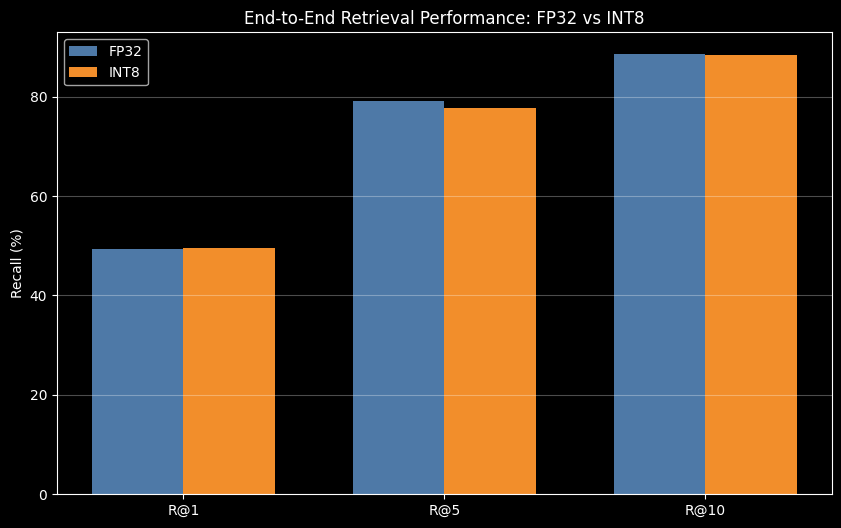

In [5]:
import numpy as np
import torch
import onnxruntime as ort
from pathlib import Path
import json
from tqdm import tqdm
from PIL import Image
import clip
from torchvision import transforms
import matplotlib.pyplot as plt

# ==================== 1. 核心评估类 ====================
class DualTowerEvaluator:
    def __init__(self,
                 fp32_image_path, fp32_text_path,
                 int8_image_path, int8_text_path,
                 image_dir, annotations_path):

        self.image_dir = Path(image_dir)

        print(f"📦 正在加载 4 个模型...")
        # 图像塔会话
        self.sess_img_fp32 = ort.InferenceSession(str(fp32_image_path))
        self.sess_img_int8 = ort.InferenceSession(str(int8_image_path))

        # 文本塔会话
        self.sess_txt_fp32 = ort.InferenceSession(str(fp32_text_path))
        self.sess_txt_int8 = ort.InferenceSession(str(int8_text_path))

        # 图像预处理 (Standard CLIP transform)
        self.preprocess = transforms.Compose([
            transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48145466, 0.4578275, 0.40821073],
                std=[0.26862954, 0.26130258, 0.27577711]
            )
        ])

        # 加载标注
        print(f"📂 正在加载 COCO 标注...")
        with open(annotations_path) as f:
            self.coco = json.load(f)

    def _run_inference(self, session, input_data):
        """通用推理包装器"""
        input_name = session.get_inputs()[0].name
        return session.run(None, {input_name: input_data})[0]

    def extract_image_features(self, precision='fp32', limit=1000):
        """提取图像特征 (FP32 或 INT8)"""
        sess = self.sess_img_fp32 if precision == 'fp32' else self.sess_img_int8
        features = []
        valid_ids = []

        # 仅使用前 limit 张图片进行测试
        target_images = self.coco['images'][:limit]

        for img_info in tqdm(target_images, desc=f"Extracting {precision.upper()} Images"):
            img_path = self.image_dir / img_info['file_name']

            if not img_path.exists():
                print(f"⚠️ 文件不存在: {img_path}")
                continue

            try:
                # 1. 加载与预处理
                img = Image.open(img_path).convert('RGB')
                # shape: [1, 3, 224, 224], type: float32
                img_tensor = self.preprocess(img).unsqueeze(0).numpy().astype(np.float32)

                # 2. 推理
                feat = self._run_inference(sess, img_tensor)

                # 3. 维度对齐 (防止有些模型输出 (1, 512) 有些输出 (512,))
                features.append(feat.reshape(1, -1))
                valid_ids.append(img_info['id'])

            except Exception as e:
                print(f"❌ 图片 {img_info['file_name']} 推理失败: {e}")
                continue

        if not features:
            raise ValueError("没有提取到任何图像特征，请检查路径设置！")

        return np.concatenate(features, axis=0), valid_ids

    def extract_text_features(self, image_ids, precision='fp32'):
        """提取对应图片的文本描述特征"""
        sess = self.sess_txt_fp32 if precision == 'fp32' else self.sess_txt_int8
        features = []

        # 构建 image_id 到 caption 的映射
        img_to_caption = {}
        for ann in self.coco['annotations']:
            if ann['image_id'] not in img_to_caption:
                img_to_caption[ann['image_id']] = ann['caption'] # 取第一条描述

        # 按 image_ids 的顺序提取对应的文本
        valid_captions = []
        for img_id in image_ids:
            if img_id in img_to_caption:
                valid_captions.append(img_to_caption[img_id])
            else:
                valid_captions.append("a photo") # 兜底策略

        for caption in tqdm(valid_captions, desc=f"Extracting {precision.upper()} Texts"):
            try:
                # 1. Tokenize (强制 int64)
                tokens = clip.tokenize([caption]).cpu().numpy().astype(np.int64)

                # 2. 推理
                feat = self._run_inference(sess, tokens)
                features.append(feat.reshape(1, -1))
            except Exception as e:
                print(f"❌ 文本 '{caption[:20]}...' 推理失败: {e}")

        return np.concatenate(features, axis=0)

    # ==================== 2. 计算指标 ====================

    def calculate_metrics(self, img_feats, txt_feats):
        """计算核心检索指标"""
        # 1. L2 归一化
        img_feats /= np.linalg.norm(img_feats, axis=1, keepdims=True)
        txt_feats /= np.linalg.norm(txt_feats, axis=1, keepdims=True)

        # 2. 计算相似度矩阵 (N x N)
        sim_matrix = txt_feats @ img_feats.T
        n_samples = sim_matrix.shape[0]

        # 3. 计算 Recall@K
        # 对每一行(Text)，正确的 Image 应该在对角线位置 (索引 i)
        # 获取每一行相似度从大到小的索引
        top_indices = np.argsort(-sim_matrix, axis=1)

        metrics = {}
        for k in [1, 5, 10]:
            correct_count = 0
            for i in range(n_samples):
                # 检查 ground truth (i) 是否在前 k 个预测中
                if i in top_indices[i, :k]:
                    correct_count += 1
            metrics[f"R@{k}"] = correct_count / n_samples * 100

        # 4. 计算 MRR
        mrr_sum = 0
        for i in range(n_samples):
            # 找到正确答案 i 在排序后的位置 (rank 从 1 开始)
            # np.where 返回的是 tuple
            rank = np.where(top_indices[i] == i)[0][0] + 1
            mrr_sum += 1.0 / rank
        metrics["MRR"] = mrr_sum / n_samples

        return metrics

    def evaluate(self, limit=1000):
        print("\n🚀 开始全量 Pipeline 对比评估...")

        # 1. FP32 链路
        print("\n🔵 --- Running FP32 Pipeline ---")
        img_fp32, ids = self.extract_image_features('fp32', limit)
        txt_fp32 = self.extract_text_features(ids, 'fp32')
        res_fp32 = self.calculate_metrics(img_fp32, txt_fp32)

        # 2. INT8 链路
        print("\n🟠 --- Running INT8 Pipeline ---")
        img_int8, _ = self.extract_image_features('int8', limit)
        txt_int8 = self.extract_text_features(ids, 'int8')
        res_int8 = self.calculate_metrics(img_int8, txt_int8)

        # 3. 打印对比报告
        self.print_report(res_fp32, res_int8)
        self.plot_comparison(res_fp32, res_int8)

    def print_report(self, fp32, int8):
        print("\n" + "="*60)
        print(f"{'Metric':<10} | {'FP32':<10} | {'INT8':<10} | {'Drop':<10}")
        print("-" * 60)
        for k in ['R@1', 'R@5', 'R@10', 'MRR']:
            v1 = fp32.get(k, 0)
            v2 = int8.get(k, 0)
            # MRR保留4位小数，R@K保留2位
            fmt = ".4f" if k == 'MRR' else ".2f"
            diff = v1 - v2
            print(f"{k:<10} | {v1:{fmt}} | {v2:{fmt}} | {diff:{fmt}}")
        print("="*60)

    def plot_comparison(self, fp32, int8):
        labels = ['R@1', 'R@5', 'R@10']
        v1 = [fp32[k] for k in labels]
        v2 = [int8[k] for k in labels]

        x = np.arange(len(labels))
        width = 0.35

        plt.figure(figsize=(10, 6))
        plt.bar(x - width/2, v1, width, label='FP32', color='#4e79a7')
        plt.bar(x + width/2, v2, width, label='INT8', color='#f28e2b')

        plt.ylabel('Recall (%)')
        plt.title('End-to-End Retrieval Performance: FP32 vs INT8')
        plt.xticks(x, labels)
        plt.legend()
        plt.grid(axis='y', alpha=0.3)

        # 保存图片
        plt.savefig("../../model/final_comparison.png")
        plt.show()

# ==================== 3. 运行入口 ====================

# 路径配置 (请确保这 4 个文件都存在)
fp32_img_path = "../../model/clip-image-encoder.onnx"
fp32_txt_path = "../../model/clip-text-encoder.onnx"

int8_img_path = "../../model/clip-image-encoder-quant-int8.onnx"
int8_txt_path = "../../model/clip-text-encoder-quant-int8.onnx"

# 数据集路径
coco_img_dir = "../../data/dataset/coco/val2017"
coco_ann_path = "../../data/dataset/coco/annotations/captions_val2017.json"

evaluator = DualTowerEvaluator(
    fp32_img_path, fp32_txt_path,
    int8_img_path, int8_txt_path,
    coco_img_dir, coco_ann_path
)

# 执行评估 (使用前 1000 张图作为测试集)
evaluator.evaluate(limit=1000)